In [1]:
import moabb
import pyriemann
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from moabb.paradigms import P300, SinglePass
from model.evaluation import CrossSubjectEvaluation, CrossSessionEvaluation
from scipy.io import loadmat
import datetime as dt
from typing import Optional

### **Build Model Graph**

In [2]:
from model.graph import *

### **Datasets**

In [3]:
def PreprocessingData(
        dataset, 
        fmin : Optional[int]=1, fmax : Optional[int]=12, resample : Optional[int]=None) -> tuple:
    """
    Preprocess EEG data to obtain standard input of evaluation

    Parameters
    ----------
    dataset : moabb dataset instance
        The dataset used.
    fmin : int, default = `1`
        The lower band for filtering.
    fmax : int, default = `12`
        The higher band for filtering.
    resample : int, default = `None`
        The resample rate, if `None`, do not resample.
    
    Return
    ----------
    (`X`, `y`, `metadata`) : tuple
        `X` is the observations, `y` is the labels and `metadata` is used to identify and locate each samplem\n
        which includes session or subject imformation for each sample.
    """
    # get the data and do preprocessing
    # Step 1: Referencing
    # Step 2: Filtering use forward–backward Butterworth bandpass filter
    # Step 3: Downsamping 
    # Step 4: Fetch single trial for 1000 ms
    paradigm = P300(fmin=fmin,fmax=fmax,resample=resample)
    X, y, metadata = paradigm.get_data(dataset)
    
    # Step 5: Windsorizing clip band with 10% and 90% quantiles
    low_quantile = np.quantile(X,q=0.1,axis=(0,2),keepdims=True)
    high_quantile = np.quantile(X,q=0.9,axis=(0,2),keepdims=True)
    X = np.clip(X,a_min=low_quantile,a_max=high_quantile)
    
    # Step 6: Scling data with channels into [-1,1]
    X_min = np.min(X,axis=(2,),keepdims=True)
    X_max = np.max(X,axis=(2,),keepdims=True)
    X = (X - X_min) / (X_max - X_min) * 2 - 1

    # encode labels
    labels = np.zeros_like(y,dtype=np.int32)
    labels[y == "Target"] = 1

    # add blocks imformation
    for sub in metadata["subject"].unique():
        idx_sub = metadata["subject"] == sub
        for sess in metadata["session"].unique():
            idx_sess = (metadata["session"] == sess) & idx_sub
            for run in metadata["run"].unique():
                idx_run = (metadata["run"] == run) & idx_sess
                n_trial = idx_run.sum()
                n_block, remains = int(n_trial / 6), n_trial % 6
                blocks = []
                for i in range(1,n_block+1):
                    blocks += ["block%d"%(i)] * 6
                blocks += ["block%d"%(n_block+1)] * remains
                metadata.loc[idx_run,"block"] = blocks

    return X, labels, metadata

In [4]:
dataset = moabb.datasets.EPFLP300()
# dataset.subject_list = [1]
X, y, metadata = PreprocessingData(dataset=dataset,resample=32)

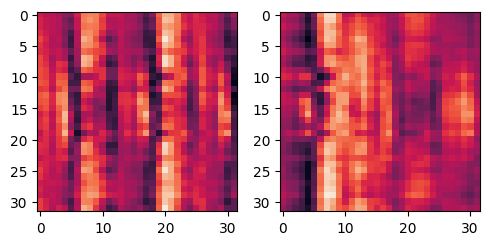

In [69]:
fig, ax = plt.subplots(1,2,figsize=(5,3))
ax = ax.flatten()
ax[0].imshow(X[y==0].mean(axis=0),cmap=sns.cm.rocket)
ax[1].imshow(X[y==1].mean(axis=0),cmap=sns.cm.rocket)
plt.tight_layout()

### **Evaluation**

In [5]:
model_1 = LassoOnly(name="Lasso",transfer="Target Only",max_steps=5000)
model_2 = LassoLassoTransfer(name="Lasso_Lasso",transfer="Transfer",max_steps=5000)
model_3 = LassoNaive(name="Lasso",transfer="Naive",max_steps=5000)

model_4 = NuclearOnly(name="Nuclear",transfer="Target Only",max_steps=5000)
model_5 = NuclearLassoTransfer(name="Nuclear_Lasso",transfer="Transfer",max_steps=5000)
model_6 = NuclearNaive(name="Nuclear",transfer="Naive",max_steps=5000)
model_7 = NuclearNuclearTransfer(name="Nuclear_Nuclear",transfer="Transfer",max_steps=5000)

In [6]:
results = CrossSessionEvaluation(
    X=X, y=y, metadata=metadata,
    models=[model_1,model_2,model_3,model_4,model_5,model_6,model_7],
    suffix="demo",
    subjects=[1,2,3,4,6,7,8,9],
    eval_subjects=[1,2,3,4],
    n_jobs=10,
    random_state=0
)

Processing Session: session_4, evaluate on: 4: 100%|██████████████| 4/4 [2:21:39<00:00, 2124.84s/it]


In [7]:
results

,model,transfer,subject,session,samples,accuracy,roc_auc,time
0,Lasso,Target Only,1,session_1,19808,0.632941,0.602351,221.302718
1,Lasso,Target Only,2,session_1,19808,0.653216,0.640054,221.302718
2,Lasso,Target Only,3,session_1,19808,0.693902,0.682391,221.302718
3,Lasso,Target Only,4,session_1,19808,0.697555,0.675615,221.302718
4,Lasso_Lasso,Transfer,1,session_1,19808,0.635294,0.602441,384.45891
...,...,...,...,...,...,...,...,...
107,Nuclear,Naive,4,session_4,19742,0.521264,0.530857,291.843384
108,Nuclear_Nuclear,Transfer,1,session_4,19742,0.646986,0.679907,413.505372
109,Nuclear_Nuclear,Transfer,2,session_4,19742,0.583529,0.641619,413.505372
110,Nuclear_Nuclear,Transfer,3,session_4,19742,0.818634,0.741431,413.505372


C:\Users\zzp99\AppData\Local\Temp\ipykernel_8584\1812581166.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\zzp99\AppData\Local\Temp\ipykernel_8584\1812581166.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


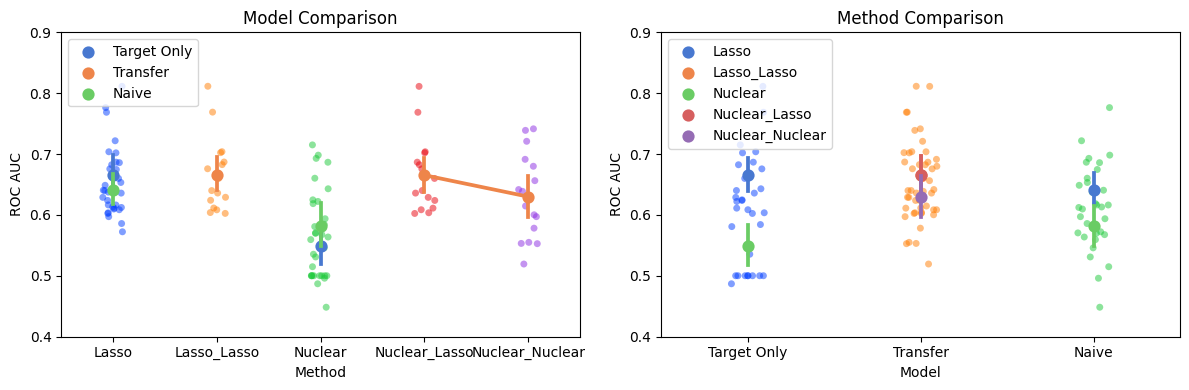

In [8]:
fig, ax = plt.subplots(1,2,facecolor="white", figsize=(12,4))
ax = ax.flatten()

sns.stripplot(
    data=results, y="roc_auc", x="model",
    ax=ax[0],jitter=True,alpha=0.5,zorder=1,palette="bright",
)
sns.pointplot(
    data=results, y="roc_auc", x="model", 
    ax=ax[0],hue="transfer",palette="muted")
ax[0].set_ylabel("ROC AUC")
ax[0].set_xlabel("Method")
ax[0].set_ylim(0.4, 0.9)
ax[0].legend(loc="upper left")
ax[0].set_title("Model Comparison")

sns.stripplot(
    data=results, y="roc_auc", x="transfer",
    ax=ax[1],jitter=True,alpha=0.5,zorder=1,palette="bright",
)
sns.pointplot(
    data=results, y="roc_auc", x="transfer", 
    ax=ax[1],hue="model",palette="muted")
ax[1].set_ylabel("ROC AUC")
ax[1].set_xlabel("Model")
ax[1].set_ylim(0.4, 0.9)
ax[1].legend(loc="upper left")
ax[1].set_title("Method Comparison")
plt.tight_layout()